# Bettensor Scoring System Weight Visualization

This notebook loads the scoring system, runs it through the final step before weight submission, and visualizes the resulting weights. This can be useful for adjusting tier allocations and understanding weight distribution across miners.

In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
from datetime import datetime, timezone, timedelta



# Set up better plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# Import bettensor modules
import bittensor as bt
from bettensor.validator.utils.scoring.scoring import ScoringSystem
from bettensor.validator.utils.database.database_manager import DatabaseManager

# Configure logging
bt.logging.set_trace(True)
bt.logging.set_debug(True)

2025-03-06 16:08:37.598 |       INFO       | bittensor:loggingmachine.py:283 | Trace enabled.
2025-03-06 16:08:37.607 |       INFO       | bittensor:loggingmachine.py:298 | Enabling debug.
2025-03-06 16:08:37.611

 |       INFO       | bittensor:loggingmachine.py:305 | Debug enabled.
2025-03-06 16:08:40.132 |       INFO       | bittensor:loggingmachine.py:359 |  - Database initialized successfully with optimized settings - 
2025-03-06 16:08:41.937 |      DEBUG       | bittensor:loggingmachine.py:354 |  - Entropy system state schema: CREATE TABLE entropy_system_state (
            id INTEGER PRIMARY KEY CHECK (id = 1),
            current_day INTEGER DEFAULT 0,
            num_miners INTEGER,
            max_days INTEGER,
            last_processed_date TEXT
        ) - 
2025-03-06 16:08:41.947 |       INFO       | bittensor:loggingmachine.py:359 |  - Current system parameters:
  Miners: 256
  Max days: 45 - 
2025-03-06 16:08:42.158 |       INFO       | bittensor:loggingmachine.py:359 |  - Database initialized successfully with optimized settings - 
2025-03-06 16:08:42.179 |       INFO       | bittensor:loggingmachine.py:359 |  - Found existing state in database with state_id=12426 - 
2025-03-06 

## 1. Connect to the Database

First, we need to connect to the database that contains all the scoring data.

In [2]:
# Specify the database path - update this with your actual database path
db_path = './bettensor/validator/state/validator.db'
print(f"Database path: {db_path}")

# Create the database manager
db_manager = DatabaseManager(db_path)

# Initialize the database connection
await db_manager.initialize()

Database path: ./bettensor/validator/state/validator.db


## 2. Load the Scoring System

Next, we'll initialize the scoring system with the database manager.

In [3]:
# Parameters for the scoring system
num_miners = 256  # Default number of miners
max_days = 45     # Default window for historical data

class NotebookScoringSystem(ScoringSystem):
    async def initialize(self):
        """Modified initialize for standalone notebook use"""
        try:
            await self.db_manager.initialize()
            await self.load_state()  # Try to load existing state
            await self.load_scores()
            
            # If no state exists, initialize with defaults
            if self.current_day is None:
                self.current_day = 0
                self.current_date = self.reference_date
                self.last_update_date = datetime.now(timezone.utc)
                self.tiers = np.ones((self.num_miners, self.max_days), dtype=np.int32)
                self.amount_wagered = np.zeros((self.num_miners, self.max_days), dtype=np.float32)
                self.init = True
            
            return True
            
        except Exception as e:
            bt.logging.error(f"Error initializing scoring system: {e}")
            import traceback
            bt.logging.error(traceback.format_exc())
            return False

scoring_system = NotebookScoringSystem(
    db_manager=db_manager,
    num_miners=256,
    max_days=45
)

init_success = await scoring_system.initialize()
print(f"Initialization success: {init_success}")

Initialization success: True


## 3. Load Existing State and Scores

Now we'll load the existing state and scores from the database.

In [6]:
# Load state and scores
await scoring_system.load_state()
await scoring_system.load_scores()

print(f"Current day: {scoring_system.current_day}")
print(f"Current date: {scoring_system.current_date}")
print(f"Number of valid UIDs: {len(scoring_system.valid_uids)}")
print(f"Number of invalid UIDs: {len(scoring_system.invalid_uids)}")

Current day: 25
Current date: 2025-03-07 00:00:00
Number of valid UIDs: 245
Number of invalid UIDs: 11


## 4. Calculate Weights

Let's calculate the weights based on the current state.

In [8]:
# Calculate weights for the current day
weights = scoring_system.calculate_weights()

# Print some basic statistics
print(f"Total weights: {np.sum(weights):.6f}")
print(f"Max weight: {np.max(weights):.6f}")
print(f"Min weight (non-zero): {np.min(weights[weights > 0]):.6f}")
print(f"Number of miners with weights: {np.sum(weights > 0)}")

Total weights: 1.000000
Max weight: 0.047990
Min weight (non-zero): 0.000000
Number of miners with weights: 245


## 5. Analysis: Weight Distribution by Tier

Now let's analyze the weight distribution by tier.

In [9]:
# Get current tiers
current_tiers = scoring_system.tiers[:, scoring_system.current_day]

# Create a dataframe with UID, tier, and weight
df = pd.DataFrame({
    'UID': range(num_miners),
    'Tier': current_tiers,
    'Weight': weights
})


# Map tier numbers to readable tier names
tier_names = {0: 'Empty', 1: 'Invalid', 2: 'Tier 1', 3: 'Tier 2', 4: 'Tier 3', 5: 'Tier 4'}
df['Tier Name'] = df['Tier'].map(lambda x: tier_names.get(x, f'Tier {x-1}'))

df.head()

,UID,Tier,Weight,Tier Name
0,0,2,7.506464e-07,Tier 1
1,1,4,8.507092e-04,Tier 3
2,2,3,5.739836e-04,Tier 2
3,3,2,2.234544e-05,Tier 1
4,4,2,2.857476e-05,Tier 1


In [10]:
# Summary statistics by tier
tier_stats = df.groupby('Tier Name').agg({
    'Weight': ['sum', 'mean', 'min', 'max', 'count'],
    'UID': 'count'
}).reset_index()

tier_stats.columns = ['Tier', 'Total Weight', 'Mean Weight', 'Min Weight', 'Max Weight', 'Count', 'UID Count']
tier_stats

,Tier,Total Weight,Mean Weight,Min Weight,Max Weight,Count,UID Count
0,Empty,0.000000,0.000000,0.000000e+00,0.000000,11,11
1,Tier 1,0.001068,0.000010,2.948623e-07,0.000052,106,106
2,Tier 2,0.012123,0.000238,5.420019e-05,0.000633,51,51
3,Tier 3,0.148887,0.002919,6.652731e-04,0.007778,51,51
4,Tier 4,0.392158,0.015686,8.170437e-03,0.026598,25,25
5,Tier 5,0.445763,0.037147,2.793892e-02,0.047990,12,12


## 6. Visualizations

Let's create visualizations to better understand the weight distribution.

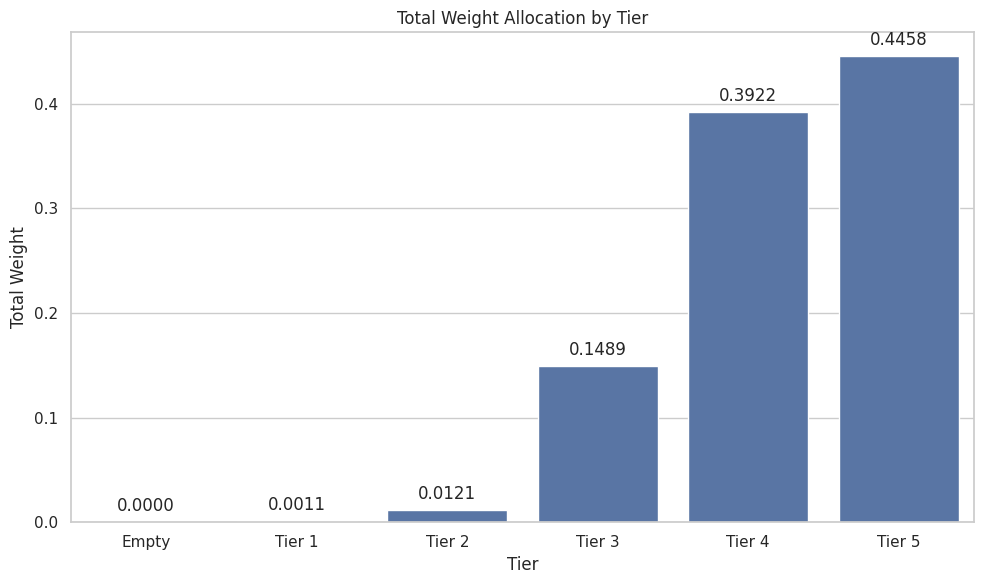

In [11]:
# 1. Total weight allocation by tier
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=tier_stats, x='Tier', y='Total Weight')
plt.title('Total Weight Allocation by Tier')
plt.ylabel('Total Weight')
plt.xlabel('Tier')

# Add value labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

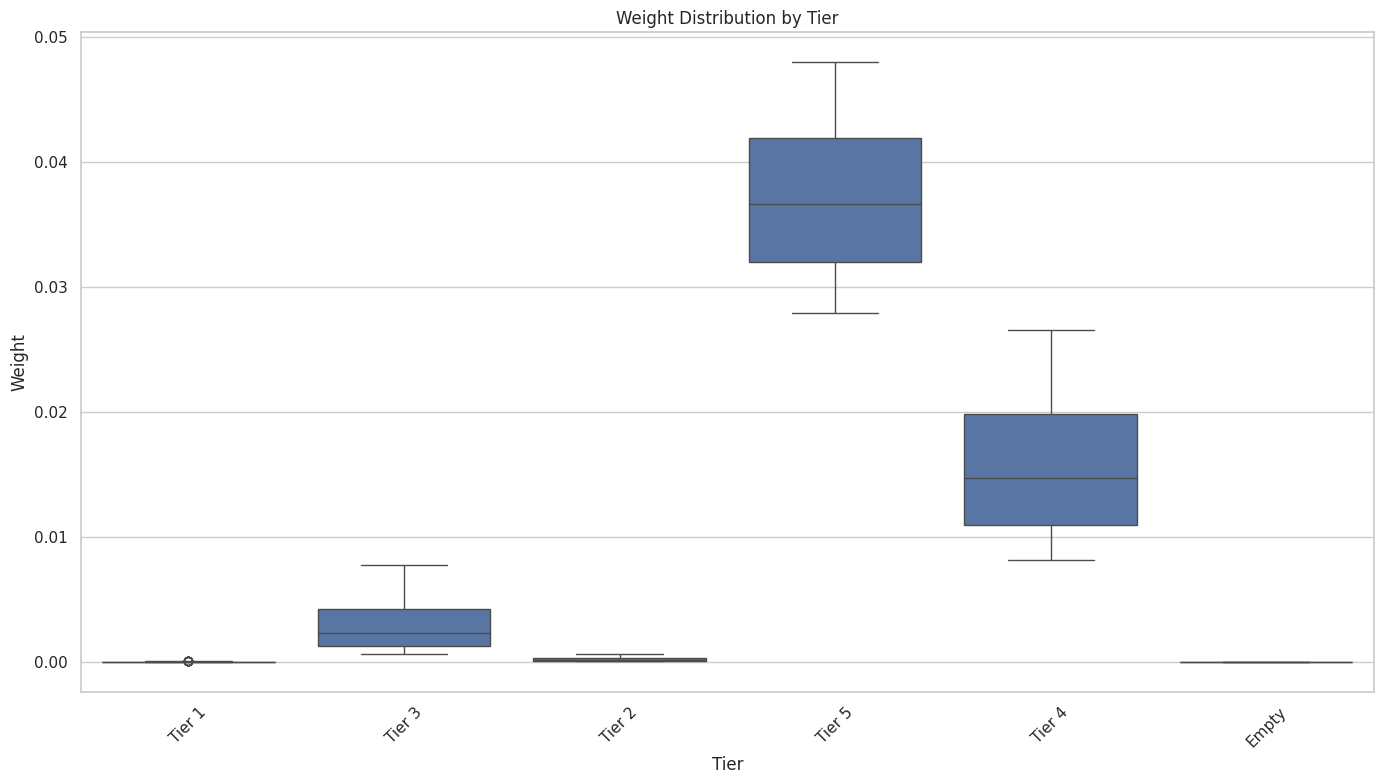

In [12]:
# 2. Weight distribution within each tier
plt.figure(figsize=(14, 8))
ax = sns.boxplot(data=df, x='Tier Name', y='Weight')
plt.title('Weight Distribution by Tier')
plt.ylabel('Weight')
plt.xlabel('Tier')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

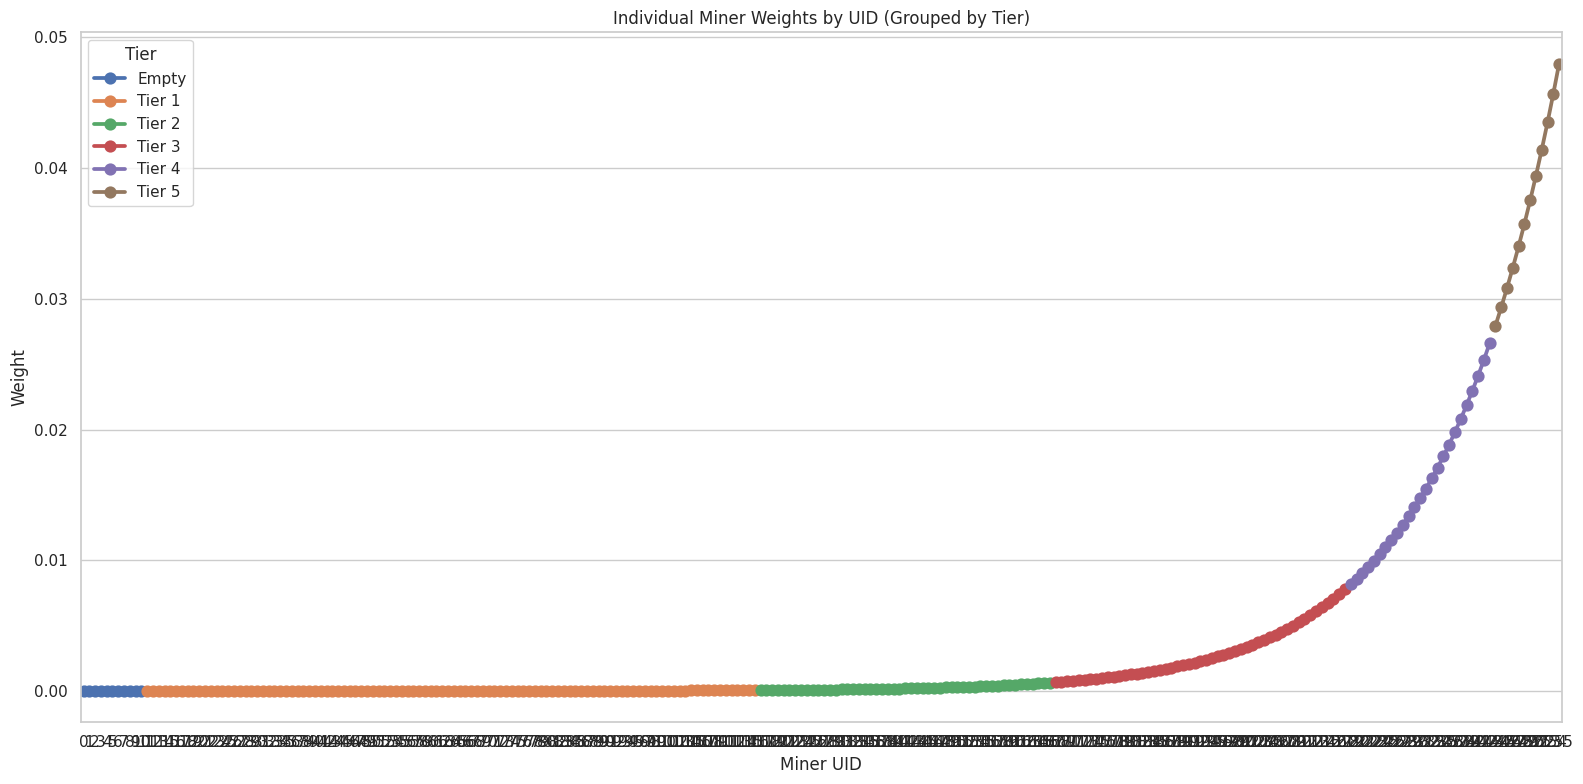

In [13]:
# 3. Individual miner weights colored by tier
plt.figure(figsize=(16, 8))
# Sort by tier and then by weight within tier
sorted_df = df.sort_values(['Weight'], ascending=[True])
sorted_df['Rank'] = range(len(sorted_df))
ax = sns.pointplot(data=sorted_df, x='Rank', y='Weight', hue='Tier Name')
plt.title('Individual Miner Weights by UID (Grouped by Tier)')
plt.ylabel('Weight')
plt.xlabel('Miner UID')
plt.legend(title='Tier')
plt.tight_layout()
plt.show()

In [ ]:
# 4. Weight distribution histograms by tier
plt.figure(figsize=(14, 10))
g = sns.FacetGrid(df, col="Tier Name", col_wrap=2, height=4, sharex=False)
g.map(sns.histplot, "Weight")
g.fig.suptitle('Weight Distribution Histograms by Tier', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## 7. Advanced Analysis: Finding Outliers and Investigating Specific Miners

In [ ]:
# Find miners with unusually high weights
high_weight_threshold = df['Weight'].mean() + 2 * df['Weight'].std()
high_weight_miners = df[df['Weight'] > high_weight_threshold]

print(f"Miners with unusually high weights (>{high_weight_threshold:.6f}):")
high_weight_miners.sort_values('Weight', ascending=False)

In [ ]:
# Function to retrieve detailed information about a specific miner
async def get_miner_details(uid):
    # Get tier history for the last 10 days
    current_day = scoring_system.current_day
    start_day = max(0, current_day - 9)
    days = list(range(start_day, current_day + 1))
    
    # Get dates for these days
    dates = []
    for day in days:
        date = scoring_system.reference_date + timedelta(days=day)
        dates.append(date.strftime('%Y-%m-%d'))
    
    # Get tiers for these days
    tiers = scoring_system.tiers[uid, start_day:current_day+1]
    
    # Get scores for these days
    clv_scores = np.zeros(len(days))
    roi_scores = np.zeros(len(days))
    risk_scores = np.zeros(len(days))
    composite_scores = np.zeros(len(days))
    
    for i, day in enumerate(days):
        tier_idx = int(tiers[i]) - 1
        if tier_idx >= 0 and tier_idx < scoring_system.num_tiers - 1:
            clv_scores[i] = scoring_system.clv_scores[uid, day]
            roi_scores[i] = scoring_system.roi_scores[uid, day]
            risk_scores[i] = scoring_system.risk_scores[uid, day]
            composite_scores[i] = scoring_system.composite_scores[uid, day, tier_idx]
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Date': dates,
        'Day': days,
        'Tier': tiers,
        'CLV Score': clv_scores,
        'ROI Score': roi_scores,
        'Risk Score': risk_scores,
        'Composite Score': composite_scores
    })
    
    return df

# Example: Get details for a specific miner
# Use a miner that has a high weight from the previous analysis
if not high_weight_miners.empty:
    uid_to_check = high_weight_miners.iloc[0]['UID']
    miner_details = await get_miner_details(int(uid_to_check))
    
    print(f"Detailed information for miner UID {uid_to_check}:")
    display(miner_details)
    
    # Plot the scores over time
    plt.figure(figsize=(14, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(miner_details['Date'], miner_details['Tier'], marker='o')
    plt.title(f'Tier History for Miner UID {uid_to_check}')
    plt.ylabel('Tier')
    plt.xticks(rotation=45)
    
    plt.subplot(3, 1, 2)
    plt.plot(miner_details['Date'], miner_details['Composite Score'], marker='o')
    plt.title(f'Composite Score History for Miner UID {uid_to_check}')
    plt.ylabel('Composite Score')
    plt.xticks(rotation=45)
    
    plt.subplot(3, 1, 3)
    plt.plot(miner_details['Date'], miner_details['CLV Score'], marker='o', label='CLV Score')
    plt.plot(miner_details['Date'], miner_details['ROI Score'], marker='s', label='ROI Score')
    plt.plot(miner_details['Date'], miner_details['Risk Score'], marker='^', label='Risk Score')
    plt.title(f'Component Scores History for Miner UID {uid_to_check}')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No miners with unusually high weights found.")

## 8. Tier Configuration Analysis

Let's analyze the current tier configurations and their impact on weight distribution.

In [ ]:
# Get tier configurations
tier_configs = scoring_system.tier_configs

# Create a DataFrame to display tier configurations
tier_config_data = []
for tier, config in tier_configs.items():
    tier_config_data.append({
        'Tier': tier_names.get(tier, f'Tier {tier-1}'),
        'Capacity': config['capacity'],
        'Incentive': config['incentive'],
        'Total Allocation': config['capacity'] * config['incentive'],
        'Window Size': config.get('window_size', 'N/A'),
        'Min Wager': config.get('min_wager', 'N/A'),
        'Min Activity': config.get('min_active_days_pct', 'N/A')
    })

tier_config_df = pd.DataFrame(tier_config_data)
tier_config_df

In [ ]:
# Visualize tier configurations
plt.figure(figsize=(12, 6))
plt.bar(tier_config_df['Tier'], tier_config_df['Total Allocation'])
plt.title('Total Allocation by Tier (Configuration)')
plt.ylabel('Total Allocation')
plt.xlabel('Tier')
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, v in enumerate(tier_config_df['Total Allocation']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# Compare configured allocation with actual allocation
tier_comparison = pd.merge(tier_config_df, tier_stats, left_on='Tier', right_on='Tier', how='left')
tier_comparison['Actual %'] = tier_comparison['Total Weight'] * 100
tier_comparison['Configured %'] = tier_comparison['Total Allocation'] * 100 / tier_comparison['Total Allocation'].sum()
tier_comparison['Difference (%)'] = tier_comparison['Actual %'] - tier_comparison['Configured %']

# Select relevant columns
comparison_cols = ['Tier', 'Configured %', 'Actual %', 'Difference (%)', 'Count']
tier_comparison[comparison_cols]

In [ ]:
# Visualize the comparison
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(tier_comparison))

plt.bar(index, tier_comparison['Configured %'], bar_width, label='Configured Allocation (%)')
plt.bar(index + bar_width, tier_comparison['Actual %'], bar_width, label='Actual Allocation (%)')

plt.xlabel('Tier')
plt.ylabel('Allocation Percentage (%)')
plt.title('Configured vs Actual Tier Allocation')
plt.xticks(index + bar_width/2, tier_comparison['Tier'])
plt.legend()

plt.tight_layout()
plt.show()

## 9. Simulation: Adjusting Tier Allocations

Let's simulate what would happen if we adjusted the tier allocations.

In [ ]:
# Function to simulate weight calculations with modified tier configurations
def simulate_weights(tier_configs_modified):
    # Create a copy of the scoring system
    sim_system = scoring_system
    
    # Store original configs
    original_configs = sim_system.tier_configs.copy()
    
    try:
        # Update configs
        for tier, config in tier_configs_modified.items():
            sim_system.tier_configs[tier] = config
        
        # Calculate weights
        sim_weights = sim_system.calculate_weights()
        
        return sim_weights
    finally:
        # Restore original configs
        sim_system.tier_configs = original_configs

# Example: Modify tier configurations to increase tier 3 and 4 allocations
modified_configs = scoring_system.tier_configs.copy()

# Adjust incentives (for example, increase tier 3 incentive by 10%)
if 3 in modified_configs:
    modified_configs[3]['incentive'] *= 1.1

# Adjust capacities (for example, increase tier 4 capacity by 5%)
if 4 in modified_configs:
    modified_configs[4]['capacity'] *= 1.05

# Simulate with modified configs
simulated_weights = simulate_weights(modified_configs)

# Compare original and simulated weights
current_tiers = scoring_system.tiers[:, scoring_system.current_day]
comparison_df = pd.DataFrame({
    'UID': range(num_miners),
    'Tier': current_tiers,
    'Original Weight': weights,
    'Simulated Weight': simulated_weights,
    'Difference': simulated_weights - weights
})

# Only include miners with weights > 0
comparison_df = comparison_df[(comparison_df['Original Weight'] > 0) | (comparison_df['Simulated Weight'] > 0)]

# Map tier numbers to readable tier names
comparison_df['Tier Name'] = comparison_df['Tier'].map(lambda x: tier_names.get(x, f'Tier {x-1}'))

# Display the comparison
comparison_df.head()

In [ ]:
# Summarize changes by tier
tier_changes = comparison_df.groupby('Tier Name').agg({
    'Original Weight': 'sum',
    'Simulated Weight': 'sum',
    'Difference': 'sum'
}).reset_index()

tier_changes['% Change'] = tier_changes['Difference'] / tier_changes['Original Weight'] * 100
tier_changes

In [ ]:
# Visualize the changes
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(tier_changes))

plt.bar(index, tier_changes['Original Weight'], bar_width, label='Original Weight')
plt.bar(index + bar_width, tier_changes['Simulated Weight'], bar_width, label='Simulated Weight')

plt.xlabel('Tier')
plt.ylabel('Total Weight')
plt.title('Original vs Simulated Weight Distribution by Tier')
plt.xticks(index + bar_width/2, tier_changes['Tier Name'])
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Plot the percentage change by tier
plt.figure(figsize=(10, 6))
plt.bar(tier_changes['Tier Name'], tier_changes['% Change'])
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Tier')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Weight Allocation by Tier')
plt.xticks(rotation=45)

# Add value labels
for i, v in enumerate(tier_changes['% Change']):
    plt.text(i, v + (1 if v >= 0 else -1), f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

## 10. Conclusion and Next Steps

Based on the visualizations and analysis, you can now make informed decisions about adjusting the tier allocations to better align with your goals. Consider the following steps:

1. Review the weight distribution across tiers
2. Analyze any outliers or unexpected weight allocations
3. Simulate different tier configurations to find the optimal distribution
4. Implement and test the changes to the tier configuration